In [57]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 12))

import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')

from utils import display

<Figure size 864x864 with 0 Axes>

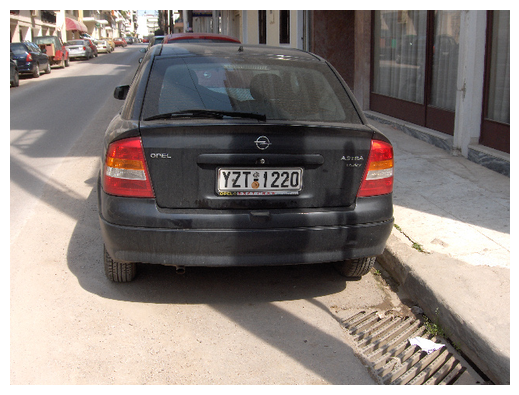

In [311]:
img = cv2.imread("images/car.png")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display(img)
#sns.distplot(img.ravel())

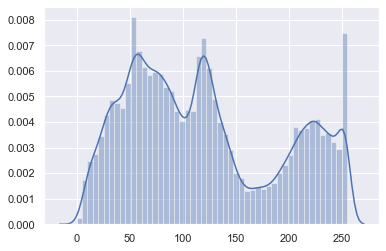

In [59]:
sns.distplot(img.ravel());

### Gamma Correction

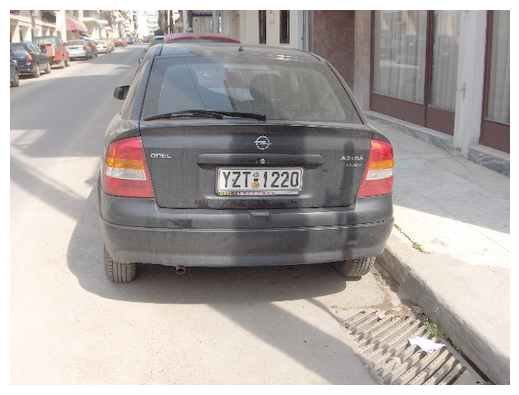

In [45]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    # creates a lookup table for all possible pixel values between 0-255
    table = np.array(
        [((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]
    )
    table = table.astype(np.uint8)
    return cv2.LUT(image, table)

# apply gamma correction
gamma_corrected = adjust_gamma(img, gamma=1.8)
display(gamma_corrected)

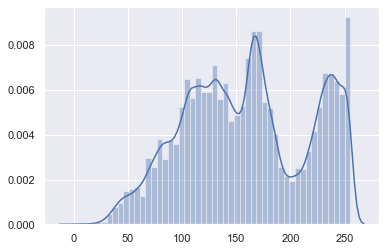

In [56]:
sns.distplot(gamma_corrected.ravel());

### Histogram Equalization

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is not the proper way for equalization of contrast. Equalization involves Intensity values of the image not the color components. So for a simple RGB color image, HE should not be applied individually on each channel. Rather, it should be applied such that intensity values are equalized without disturbing the color balance of the image. 

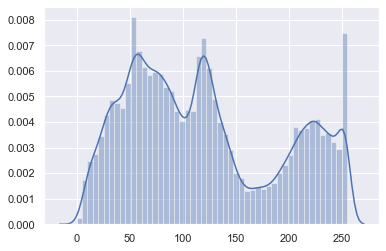

In [60]:
sns.distplot(img.ravel());

#### Intensity Image equalization 

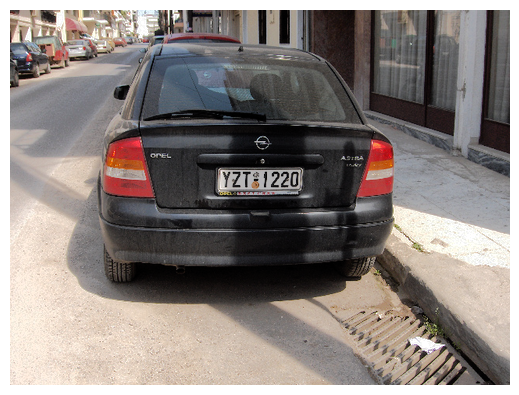

In [62]:
# 1. HSV/HSL 

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
v_eq = cv2.equalizeHist(v)
hsv_eq = cv2.merge([h, s, v_eq])
rgb_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)
display(rgb_eq)

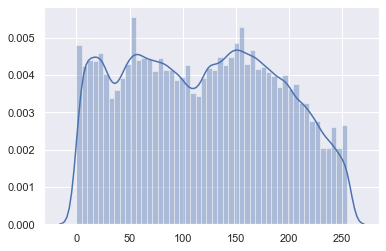

In [63]:
sns.distplot(rgb_eq.ravel());

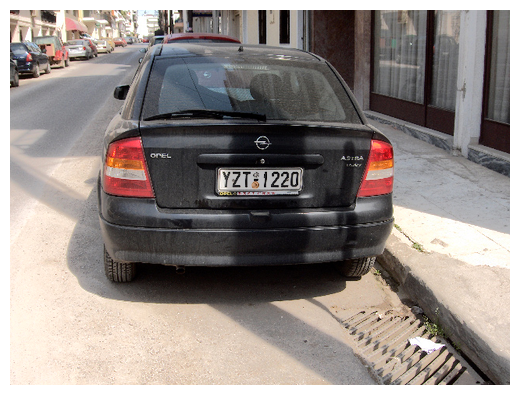

In [69]:
# 2. YCrCb 

YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y, Cr, Cb = cv2.split(YCrCb)
Y_eq = cv2.equalizeHist(Y)
YCrCb_eq = cv2.merge([Y_eq, Cr, Cb])
rgb_eq = cv2.cvtColor(YCrCb_eq, cv2.COLOR_YCrCb2BGR)
display(rgb_eq)

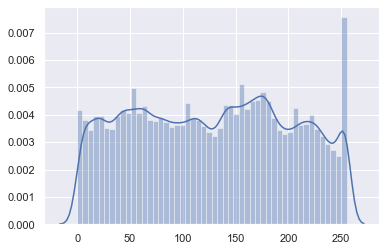

In [70]:
sns.distplot(rgb_eq.ravel());

#### Individual Channel Equalization

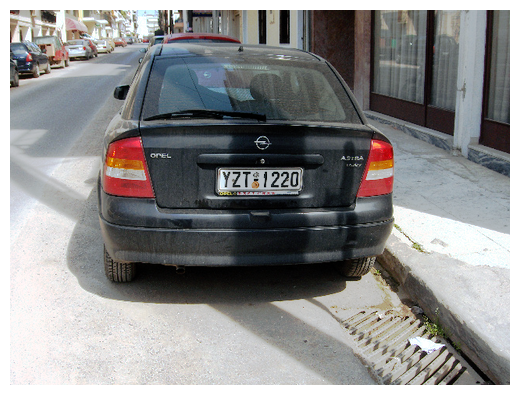

In [75]:
b, g, r = cv2.split(img)
b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

rgb_eq = cv2.merge([b_eq, g_eq, r_eq])
display(rgb_eq)

# NOTE: Notice the presence of false colors in the image 

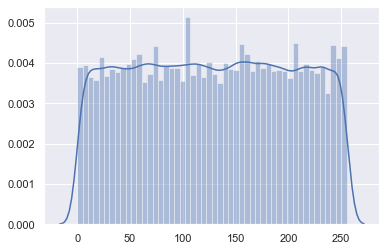

In [76]:
sns.distplot(rgb_eq.ravel());

### Inversion

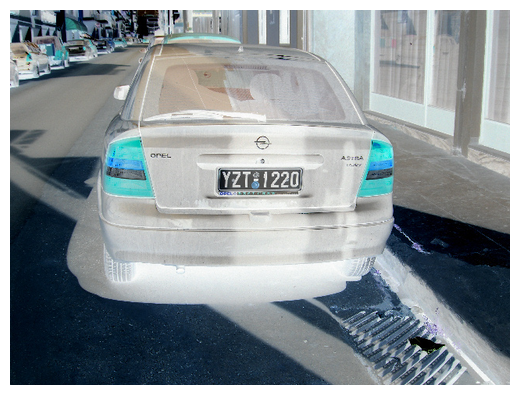

In [82]:
def inversion(img, blur=False):
    if blur:
        img = cv2.medianBlur(img, 3)
    return 255 - img

inverted = inversion(img)
display(inverted)

### Normalization

Min: 0.000, Max: 255.000, Mean: 120.084, Std: 71.135
Min: 0.000, Max: 255.000, Mean: 103.209, Std: 94.491


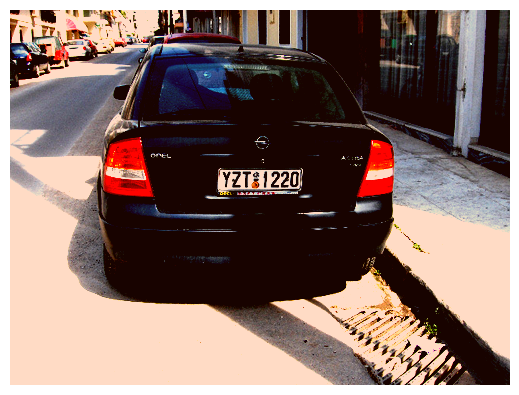

In [145]:
def normalize(img, offset=0.5):
    chs = []
    for ch in cv2.split(img):
        mu, sigma = cv2.meanStdDev(ch)
        chs.append(np.clip(ch, mu - offset*sigma, mu + offset*sigma).astype(np.uint8))
    clipped = cv2.merge(chs)
    return cv2.normalize(clipped, clipped, 0, 255, norm_type=cv2.NORM_MINMAX)

# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f"Min: {np.min(img):.3f}, Max: {np.max(img):.3f}, Mean: {np.mean(img):.3f}, Std: {np.std(img):.3f}")
normalized = normalize(img)
print(f"Min: {np.min(normalized):.3f}, Max: {np.max(normalized):.3f}, Mean: {np.mean(normalized):.3f}, Std: {np.std(normalized):.3f}")
display(normalized)

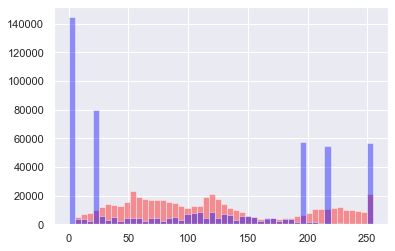

In [148]:
bins = 50
sns.distplot(img.ravel(), bins=bins, color="red", kde=False);
sns.distplot(normalized.ravel(), bins=bins, color="blue", kde=False);

### Sharpening 

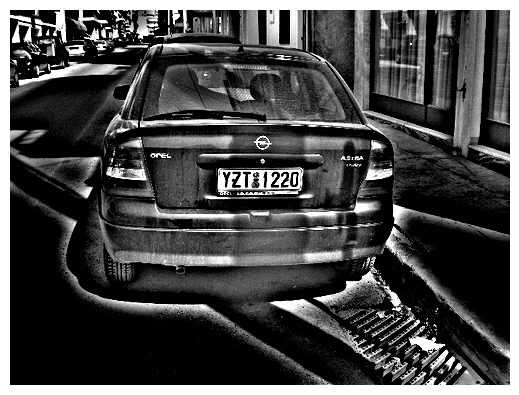

In [312]:
def sharpen(img, sigmaX=10, alpha=4, beta=-5, gamma=128):
    blur = cv2.GaussianBlur(img, (0, 0), sigmaX)
    # dst(I)=saturate(src1(I)∗alpha + src2(I)∗beta + gamma)
    sharped = cv2.addWeighted(img, alpha, blur, beta, gamma)
    return sharped

#img = cv2.imread("./anpr/data/mwuqu.jpg")
#img = cv2.imread("./anpr/data/ii1zy.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sharped_image = sharpen(gray, sigmaX=10, beta=-5, gamma=128)
display(sharped_image, flip=False, cmap="gray")

100
4.46875 32 143
3.375 32 108
3.1481481481481484 27 85
3.816793893129771 131 500


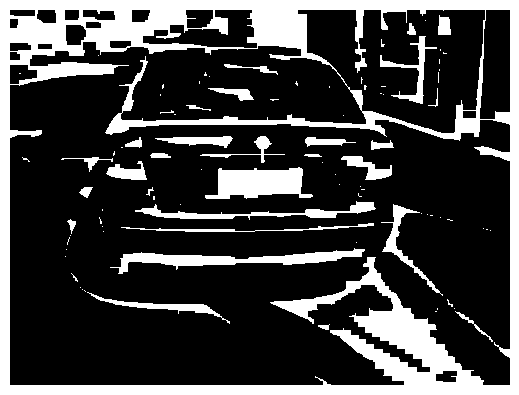

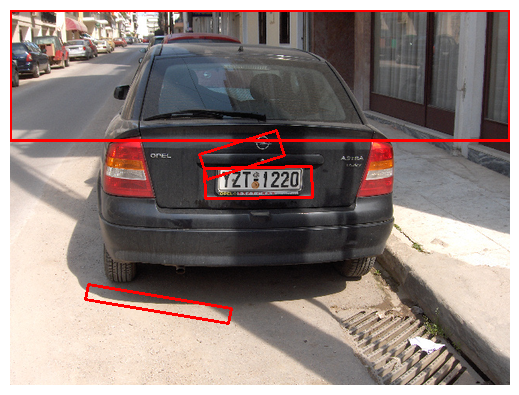

In [313]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
# blackhat = cv2.morphologyEx(sharped_image, cv2.MORPH_BLACKHAT, rect_kernel)

# display(blackhat, flip=False, cmap="gray")

light = cv2.threshold(sharped_image, 150, 255, cv2.THRESH_BINARY)[1]
# light = cv2.GaussianBlur(light, (3, 3), 0)
light = cv2.morphologyEx(light, cv2.MORPH_CLOSE, rect_kernel)

display(light, flip=False, cmap="gray")


cnts = cv2.findContours(light.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print(len(cnts))
plates = []
# loop over the contours
for c in cnts:
    # grab the bounding box associated with the contour and compute the area and
    # aspect ratio
    (w, h) = cv2.boundingRect(c)[2:]
    aspect_ratio = w / float(h)
    # print(aspect_ratio)
    # compute the rotated bounding box of the region
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))
    if (3 < aspect_ratio < 6) and h > 25 and w > 60:
        print(aspect_ratio, h, w)
        plates.append(box)
        
img1 = img.copy()     
for lp_box in plates:
    lp_box = np.array(lp_box).reshape((-1, 1, 2)).astype(np.int32)
    cv2.drawContours(img1, [lp_box], -1, (0, 0, 255), 2)
    
display(img1)